# Single neuron dynamics

In [ ]:
# note: run this example with Python3 kernel

## libs and path

In [1]:
try:
    import pyNN.spiNNaker as sim
except ModuleNotFoundError:
    import pyNN.brian2 as sim
    
from pyNN import space 
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pickle
import pandas as pd
import seaborn as sns
import time
import datetime

fileName = 'eg_single-neuron' 
savePath = f'../outputs/'
dt_string = datetime.datetime.today().isoformat() # ISO8601 ! :-)
tag = dt_string 
saveName = f'{savePath}-{fileName}-{tag}'
saveName

INFO       Cache size for target 'cython': 1175478576 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the '/home/bbpnrsoa/.cython/brian_extensions' directory. [brian2]


'../outputs/-eg_single-neuron-2023-11-17T17:46:16.194253'

## sim setup

In [2]:

sim.setup(
        timestep=1, # [ms]
        min_delay=1, # [ms]
        max_delay=100) # [ms]

simtime = 500 #ms

## network design

In [3]:

MODEL=sim.IF_cond_exp
N_CELLS = 1
PARS={'v_rest': -65.0, 
      'v_thresh': -37.0, 
      'v_reset': -80.0,
      'cm': 1.0, 
      'tau_m': 20.0, 
      'tau_refrac': 0.1, 
      'tau_syn_E': 5.0, 
      'tau_syn_I': 5.0, 
      'e_rev_E': 0.0, 
      'e_rev_I': -70.0, 
      'i_offset': 0.0}

cell0 = sim.Population(N_CELLS, 
                      MODEL, 
                      cellparams=PARS,
                      label='cell0')

cell0.record(['v', 'gsyn_exc', 'gsyn_inh', 'spikes'])


## input design

In [4]:
# not implemented in sPyNNaker
pulse = sim.ACSource(start=100, #ms
                     stop=400, #ms
                     amplitude=10, #nA
                     frequency=50,  #Hz
                     )

pulse.inject_into(cell0)
pulse.record()



# simulation run

In [5]:
tic = time.time()
sim.run(simtime)
toc = time.time() - tic
print(f'simulation time: {toc} [s]')


INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.02s, trying other methods took 0.08s). [brian2.stateupdaters.base.method_choice]


simulation time: 0.5972404479980469 [s]


# save results

In [6]:
for recording in ['v', 'gsyn_inh', 'gsyn_exc', 'spikes']:
    cell0.write_data(f'{saveName}-{recording}.pkl')

In [7]:
cell0.get_data()

Block with 1 segments
name: 'cell0'
description: 'Population "cell0"\n    Structure   : Line\n    Local cells : 1\n    Cell type   : IF_cond_exp\n    ID range    : 0-0\n    First cell on this node:\n      ID: 0\n      {}'
annotations: {'size': 1,
  'first_index': 0,
  'last_index': 1,
  'first_id': 0,
  'last_id': 0,
  'label': 'cell0',
  'simulator': 'Brian2',
  'dt': 1.0,
  'mpi_processes': 1}
rec_datetime: datetime.datetime(2023, 11, 17, 17, 46, 16, 922822)
# segments (N=1)
0: Segment with 3 analogsignals, 1 spiketrains
   name: 'segment000'
   description: 'Population "cell0"\n    Structure   : Line\n    Local cells : 1\n    Cell type   : IF_cond_exp\n    ID range    : 0-0\n    First cell on this node:\n      ID: 0\n      {}'
   # analogsignals (N=3)
   0: AnalogSignal with 1 channels of length 501; units uS; datatype float64 
      name: 'gsyn_exc'
      annotations: {'source_ids': array([0]), 'source_population': 'cell0'}
      sampling rate: 1.0 1/ms
      time: 0.0 ms to 501.0 

In [8]:
v0=cell0.get_data(variables=['v']).segments[0].analogsignals[0]
ge0=cell0.get_data(variables=['gsyn_exc']).segments[0].analogsignals[0]
gi0=cell0.get_data(variables=['gsyn_inh']).segments[0].analogsignals[0]
spikes0=cell0.get_data(variables=['spikes']).segments[0].spiketrains[0]
i=pulse.get_data()

cell0 spikes: {0: 6}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
WARNING    <ipython-input-9-b25e7f1fa30d>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(' ')
 [py.warnings]


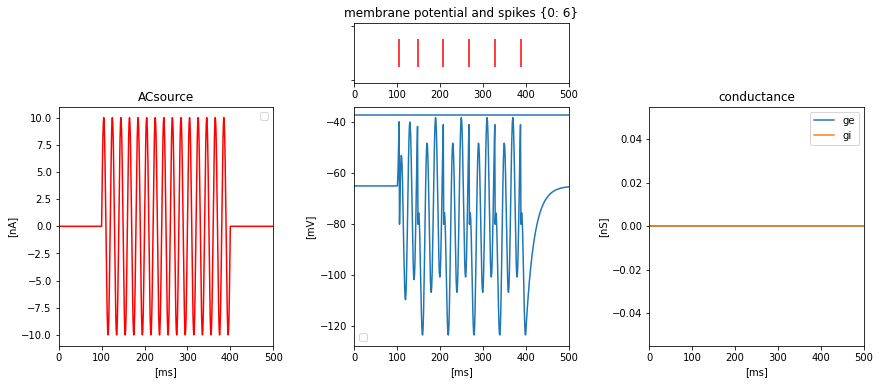

In [9]:
print(f'cell0 spikes: {cell0.get_spike_counts()}')

fig, ax = plt.subplots(1,3, figsize=(13,5))
fig.tight_layout(pad=5)
ax=ax.flatten()
ax[0].plot(i, 'r', alpha=1)
ax[1].plot(v0)
ax[2].plot(ge0, label='ge')
ax[2].plot(gi0, label='gi')

ax[1].axhline(y=cell0[0].v_thresh)
#ax2=ax[1].twinx()
ax2=ax[1].inset_axes([0,1.1,1,0.25])
ax2.set_xlim(0, simtime)
ax2.eventplot(np.array(list(spikes0)).T, color='r', alpha=1, )

ax[0].set_ylabel('[nA]')
ax[0].set_title('ACsource')
ax[1].set_title(f'membrane potential and spikes {cell0.get_spike_counts()}')
ax[2].set_title('conductance')

ax[1].set_ylabel('[mV]')
ax[2].set_ylabel('[nS]')

[ax[i].legend() for i in range(3)]
[ax[i].set_xlim(0, simtime) for i in range(3)]
[ax[i].set_xlabel('[ms]') for i in range(3)]
ax2.set_yticklabels(' ')

VAR=[]

